# Comparison of a simulated and a real trace of HPL

In [1]:
import io
import os
import zipfile
import pandas
import yaml
from plotnine import *
import plotnine
import sys
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x, usecols=None):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

In [2]:
reality_archive = 'geometry/9/grenoble_2020-08-13_1944251.zip'
simgrid_dir = '../smpi_hpl/geometry/31/'
simgrid_archives = [os.path.join(simgrid_dir, f) for f in os.listdir(simgrid_dir) if f.endswith('.zip')]
sizes = list(read_csv(reality_archive, 'results.csv').matrix_size)
for archive in simgrid_archives:
    assert sizes == list(read_csv(archive, 'results.csv').matrix_size)
print(sizes)

[250000]


In [3]:
def filter_pajeng(pajeng_output, keep):
    lines = pajeng_output.split(b'\n')
    lines = [l for l in lines if l.startswith(keep.encode())]
    return b'\n'.join(lines)

def _read_paje_state(archive_name, csv_name, has_msg_size=False, replace_func=('MPI', 'MPI')):
    columns=['type', 'rank', 'container', 'start', 'end', 'duration', 'level', 'function']
    if has_msg_size:
        columns.append('tmp')
    df = read_csv(archive_name, csv_name, columns=columns, filter_func=lambda x: filter_pajeng(x, 'State'))
    df['function'] = df['function'].str.replace(*replace_func).str.strip()  # for some reason Simgrid uses PMPI_Wait and not MPI_Wait
    df['msg_size'] = -1
    if has_msg_size:
        df.loc[df['function'].isin(['MPI_Recv', 'MPI_Send', 'MPI_Isend', 'MPI_Irecv']), 'msg_size'] = df['tmp']
        df['msg_size'] = df['msg_size'].astype(int)
    df['rank'] = df['rank'].str.slice(5).astype(int)  # changing 'rank42' into 42
    return df

def read_mpi_state(archive_name, csv_name):
    df = _read_paje_state(archive_name, csv_name, True)
    return df

def read_smpi_state(archive_name, csv_name):
    df = _read_paje_state(archive_name, csv_name, True, ('PMPI', 'MPI'))
    df['rank'] = -df['rank']  # in SMPI, we have 'rank-42' and not 'rank42', so there remains a - that we should remove
    return df

def read_smpi_link(archive_name, csv_name):
    df = read_csv(archive_name, csv_name,
                  columns=['type', 'level', 'container', 'start', 'end', 'duration', 'commType', 'src', 'dst', 'msg_size'],
                  filter_func=lambda x: filter_pajeng(x, 'Link'))
    df['src'] = df['src'].str.slice(6).astype(int)  # changing 'rank42' into 42
    df['dst'] = df['dst'].str.slice(6).astype(int)  # changing 'rank42' into 42
#    df['remote'] = (df['src'] // 32) != (df['dst'] // 32)
    return df

def read_archive(archive_name, mode, exp_id, drop_func=['MPI_Comm_rank', 'MPI_Comm_size', 'MPI_Comm_split', 'MPI_Comm_free', 'MPI_Init', 'MPI_Finalize']):
    assert mode in ('reality', 'simgrid')
    print('# Mode: %s' % mode)
    blas_col = ['file', 'line', 'function', 'rank', 'timestamp', 'duration', 'm', 'n', 'k']
    blas_trace = read_csv(archive_name, 'trace_blas_%d.csv' % exp_id, columns=blas_col)
    old_len = len(blas_trace)
   # blas_trace = blas_trace[(blas_trace['m'] != 0) & (blas_trace['n'] != 0) & (blas_trace['k'] != 0)]
    print('\tBLAS trace: %6d lines (removed %d lines with null sizes)' % (len(blas_trace), old_len - len(blas_trace)))
    blas_trace['start'] = blas_trace.timestamp
    blas_trace['end'] = blas_trace.timestamp + blas_trace.duration
#    blas_trace = blas_trace[['function', 'start', 'end', 'rank', 'm', 'n', 'k']]
    blas_trace['msg_size'] = -1
    blas_trace['kind'] = 'BLAS'
    if mode == 'reality':
        mpi_trace = read_mpi_state(archive_name, 'trace_mpi_%d.csv' % exp_id)
    else:
        mpi_trace = read_smpi_state(archive_name, 'trace_mpi_%d.csv' % exp_id)
    print('\tMPI  trace: %6d lines' % len(mpi_trace))
    mpi_trace = mpi_trace[['function', 'start', 'end', 'rank', 'msg_size']]
    mpi_trace['kind'] = 'MPI'
    df = pandas.concat([blas_trace, mpi_trace])
    df['mode'] = mode
    df['rank+1'] = df['rank'] + 1
    old_len = len(df)
    df = df[~df['function'].str.strip().isin(drop_func)]
    print('Removed %d events with functions in %s' % (old_len-len(df), ', '.join(drop_func)))
    df['duration'] = df['end'] - df['start']
    df['function'] = df['function'].str.strip()
    return df

traces = None
nbrow_limit = 2000000
for i, size in enumerate(sizes):
    print('Exp %d (matrix_size=%d)' % (i, size))
    for filename, mode in [(reality_archive, 'reality')] + [(archive, 'simgrid') for archive in simgrid_archives]:
        tmp_trace = read_archive(filename, mode, i)
        tmp_trace['matrix_size'] = size
#        if len(tmp_trace) > nbrow_limit:
#            sys.stderr.write('WARNING: dataframe for exp %d (matrix_size=%d) has %d rows, keeping %d' % (i, size, len(tmp_trace), nbrow_limit))
#        tmp_trace = tmp_trace.head(n=nbrow_limit)
        if mode == 'simgrid':
            expfiles = get_yaml(filename, 'info.yaml')['expfile']
            dgemmfile = [f for f in expfiles if f.endswith('.yaml')]
            assert len(dgemmfile) == 1
            tmp_trace['dgemm_file'] = dgemmfile[0]
        if traces is not None:
            traces = pandas.concat([traces, tmp_trace])
        else:
            traces = tmp_trace

traces.head()

Exp 0 (matrix_size=250000)
# Mode: reality
	BLAS trace:  54981 lines (removed 0 lines with null sizes)
	MPI  trace:  64812 lines
Removed 31206 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize
# Mode: simgrid
	BLAS trace: 297338 lines (removed 0 lines with null sizes)
	MPI  trace: 8382507 lines
Removed 960 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize


/home/tom/.cache/pypoetry/virtualenvs/mpi-calibration-V_fyVHYp-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:21: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


,dgemm_file,duration,end,file,function,k,kind,line,m,matrix_size,mode,msg_size,n,rank,rank+1,start,timestamp
0,NaN,0.000000,3.818850,../HPL_pdtest.c,smpi_marker,NaN,BLAS,202.0,NaN,250000,reality,-1,NaN,0,1,3.818850,3.818850
1,NaN,0.000209,3.819102,../HPL_dlocmax.c,idamax,NaN,BLAS,125.0,250000.0,250000,reality,-1,NaN,0,1,3.818893,3.818893
2,NaN,0.000010,3.819115,../HPL_pdmxswp.c,dcopy,NaN,BLAS,165.0,128.0,250000,reality,-1,NaN,0,1,3.819105,3.819105
3,NaN,0.000003,3.819120,../HPL_pdmxswp.c,dcopy,NaN,BLAS,167.0,128.0,250000,reality,-1,NaN,0,1,3.819117,3.819117
4,NaN,0.000159,3.819284,../HPL_pdpancrT.c,dscal,NaN,BLAS,214.0,249999.0,250000,reality,-1,NaN,0,1,3.819125,3.819125


## HPL result

In [4]:
res = read_csv(reality_archive, 'results.csv')
res[['matrix_size', 'time']].sort_values(by='matrix_size')

,matrix_size,time
0,250000,56.77


In [5]:
res = []
for archive in simgrid_archives:
    tmp = read_csv(archive, 'results.csv')
    res.append(tmp)
res = pandas.concat(res)
res[['matrix_size', 'time']].sort_values(by='matrix_size')

,matrix_size,time
0,250000,57.39


In [6]:
traces[(traces['mode'] == 'simgrid') & (traces['kind'] == 'MPI')].groupby('function')[['start']].count()

,start
function,
MPI_Bcast,960
MPI_Recv,10575
MPI_Send,10575
computing,8359437


In [7]:
traces = traces[traces['function'] != 'computing']

## Checking the parameters

In [8]:
parameters = read_csv(simgrid_archives[0], 'exp_hpl_trace.csv')
for archive in simgrid_archives:
    assert read_csv(archive, 'exp_hpl_trace.csv').equals(parameters)
parameters

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process
0,250000,128,1,480,1,2,2,1,0,8,32,1


In [9]:
read_csv(reality_archive, 'exp_hpl.csv')

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process
0,250000,128,1,480,1,2,2,1,0,8,32,1


In [10]:
platforms = set([zipfile.ZipFile(archive).read('dahu_ringrong_fixed.xml').decode('ascii') for archive in simgrid_archives])
assert len(platforms) == 1
print(platforms.pop())

<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="network/weight-S" value="0"/>
        <prop id="network/crosstraffic" value="false"/>
        <prop id="network/TCP_gamma" value="-1"/>
        <prop id="maxmin/precision" value="1e-09"/>
        <prop id="surf/precision" value="1e-12"/>
        <prop id="maxmin/concurrency-limit" value="-1"/>
        <prop id="smpi/os" value="0:1.0390044058501086e-06:2.2582693391522874e-11;8000:0.0003468233639105082:0.0;15798:0.0002888553072948145:2.3011264127198946e-09;64000:0.0:0.0;6000000:0.0:0.0;42672591:0.0:0.0;160097505:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.1606281334276814e-06:2.5405126421726545e-11;8000:4.813055334777501e-07:1.3709188743427587e-10;15798:6.405086625588439e-07:1.4914447755480297e-10;64000:0.0:0.0;6000000:0.0:0.0;42672591:0.0:0.0;160097505:0.0:0.0"/>
        <prop id="smpi/ois" value="0:9.11412757619

In [11]:
from IPython.display import display, Markdown
for archive in simgrid_archives:
    installfile = get_yaml(archive, 'info.yaml')['installfile']
    installfile_content = zipfile.ZipFile(archive).read(installfile).decode()
    display(Markdown('Archive name: %s' % archive))
    display(Markdown('```yaml\n%s\n```' % installfile_content))

/home/tom/.cache/pypoetry/virtualenvs/mpi-calibration-V_fyVHYp-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:21: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


Archive name: ../smpi_hpl/geometry/31/grenoble_2020-09-16_1948197.zip

```yaml
trace_execution: True
terminate_early: True
insert_bcast: True
stochastic_network: False
loopback_model: True
stochastic_cpu: True
disable_hpl_kernels: False
disable_nondgemm_randomness: False
random_seed: 105
simgrid_version: 51ba1c46d1453dfd7076e507f1d13d678dcce5a3

```

In [12]:
non_null_traces = traces[(traces['m'] != 0) & (traces['n'] != 0) & (traces['k'] != 0)].copy()
print(len(non_null_traces), len(traces))
non_null_traces['func'] = non_null_traces['function']
non_null_traces.loc[~non_null_traces['function'].isin(['dgemm', 'dtrsm', 'MPI_Send', 'MPI_Recv']), 'func'] = 'other'

164159 408035


## Visualizing the trace (non-null sizes)

In [13]:
def plot(df, wrap=None, lines=[], hard_lines=False):
    gc = ggplot(df) + geom_rect(aes(xmin='start', xmax='end', ymin='rank', ymax='rank+1',fill='func')) + theme_bw()
    if wrap:
        gc = gc + facet_wrap(wrap, labeller='label_both', ncol=2)
        guide = 'legend'
    else:
        guide = 'legend'
    gc = gc + scale_fill_brewer(type='qualitative', palette='Dark2', guide=guide)
    if lines:
        gc = gc + scale_x_continuous(breaks = lines) + expand_limits(x=max(lines))
        if hard_lines:
            for line in lines:
                gc = gc + geom_vline(xintercept=line, linetype='dashed', alpha=0.5)
    return gc

def plot_bounded(df, start, end, ranks, wrap=['mode', 'kind']):
    df = df[df['rank'].isin(ranks)]
    df = df[(df['end'] >= start) & (df['start'] <= end)].copy()
    df.loc[df['start'] < start, 'start'] = start
    df.loc[df['end'] > end, 'end'] = end
    return plot(df, wrap) + xlim(start, end) + ggtitle('Events between %.1fs and %.1fs for ranks in %s' % (start, end, ranks))

def my_range(start, stop, nb_steps):
    interval = (stop-start)/(nb_steps+1)
    val = start
    result = []
    for _ in range(nb_steps+2):
        result.append(val)
        val += interval
    return result

In [14]:
traces['function'].unique()

array(['smpi_marker', 'idamax', 'dcopy', 'dscal', 'dgemv', 'dtrsm',
       'dgemm', 'HPL_dlatcpy', 'HPL_dlacpy', 'HPL_pdgesK2:factor',
       'HPL_pdgesvK2:broadcast', 'HPL_pdgesvK2:wait', 'second_bcast',
       'HPL_dlaswp00N', 'HPL_pdupdateTT', 'HPL_pdgesK2:update', 'daxpy',
       'dtrsv', 'HPL_pdgesv', 'MPI_Send', 'MPI_Recv', 'MPI_Bcast'],
      dtype=object)

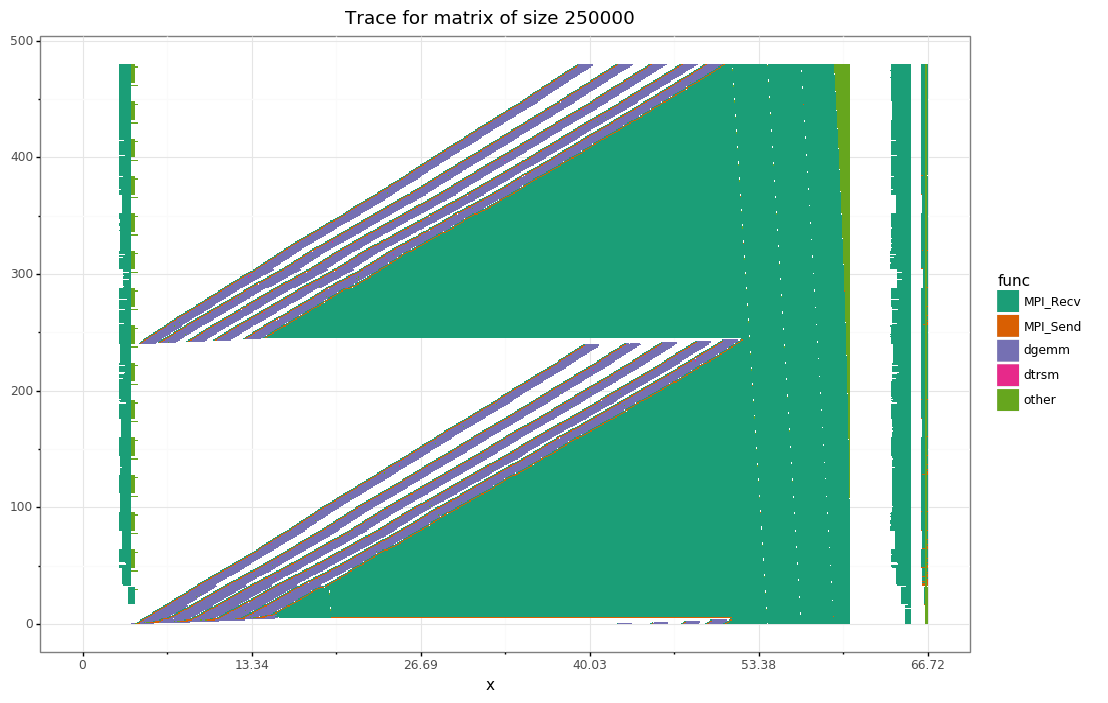

<ggplot: (-9223363283544305166)>


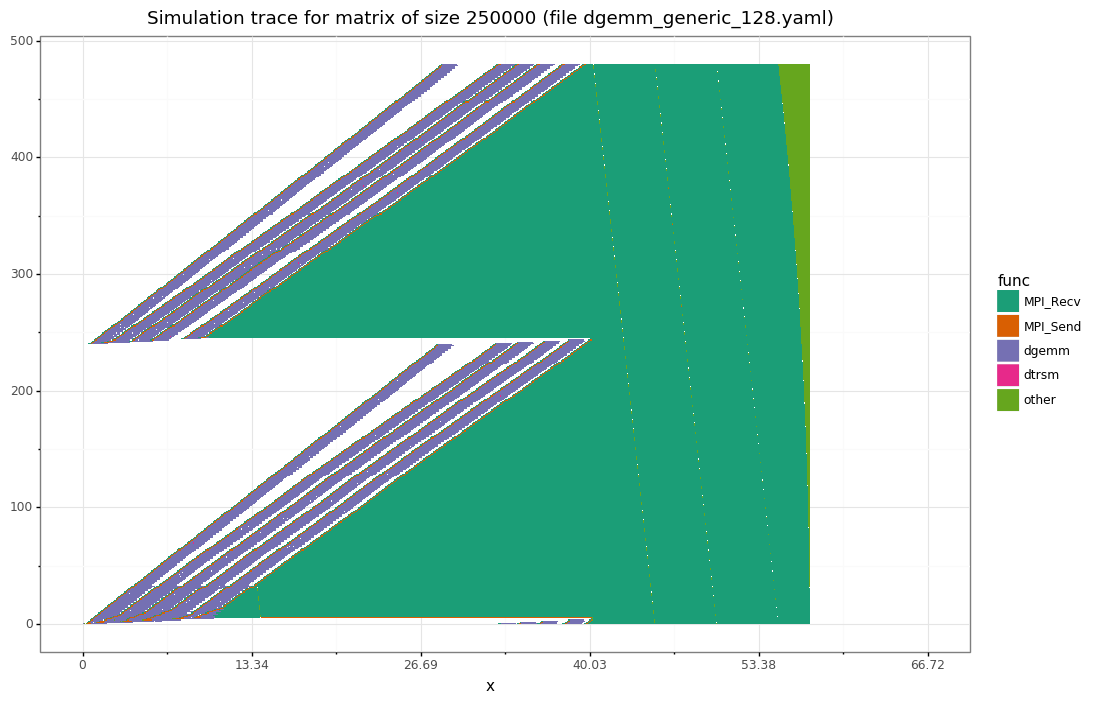

<ggplot: (-9223363283555780103)>


In [15]:
for size in sorted(non_null_traces.matrix_size.unique()):
    tmp = non_null_traces[(non_null_traces['matrix_size'] == size)]
    special_functions = {'HPL_bcast', 'HPL_pdgesv', 'HPL_pdupdateTT', 'HPL_pdges'}
    for func in special_functions:
        tmp = tmp[~tmp['function'].str.startswith(func)]
    lines = my_range(non_null_traces.start.min(), non_null_traces.start.max(), 4)
    print(plot(tmp[tmp['mode'] == 'reality'], lines=lines) + ggtitle('Trace for matrix of size %d' % size))
    for dgemm_file in sorted(traces[traces['mode'] != 'reality']['dgemm_file'].unique()):
        print(plot(tmp[(tmp['mode'] != 'reality') & (tmp['dgemm_file'] == dgemm_file)], lines=lines) + ggtitle('Simulation trace for matrix of size %d (file %s)' % (size, dgemm_file)))

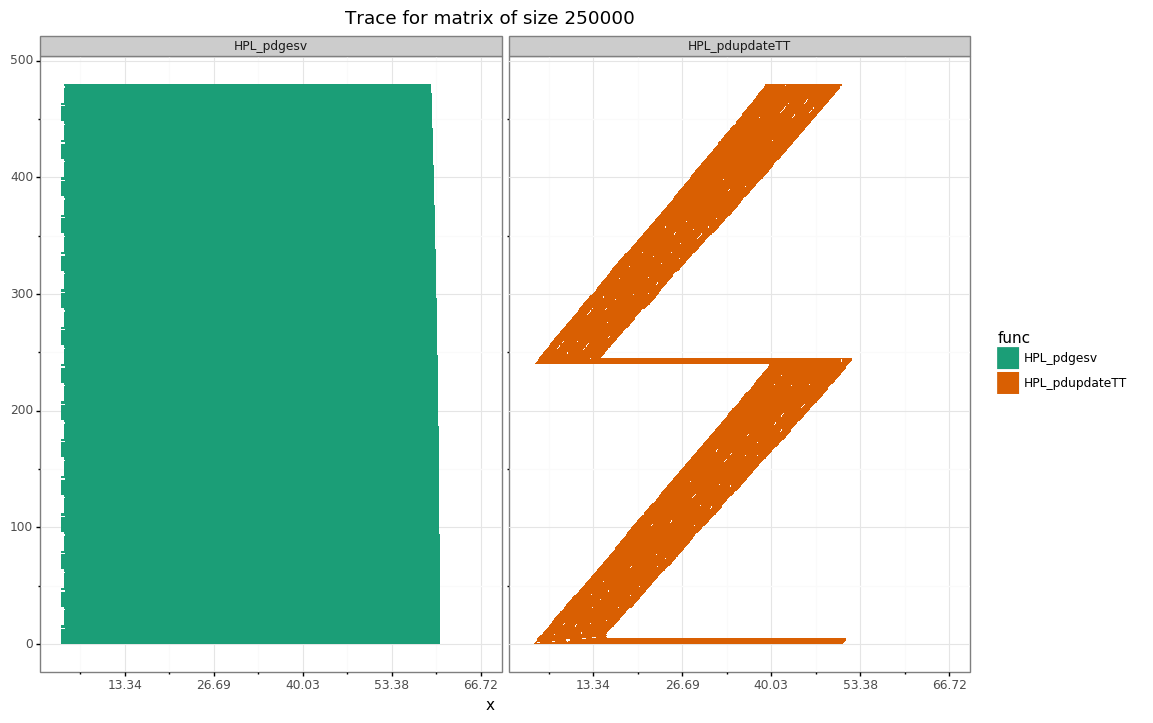

<ggplot: (8753307023666)>


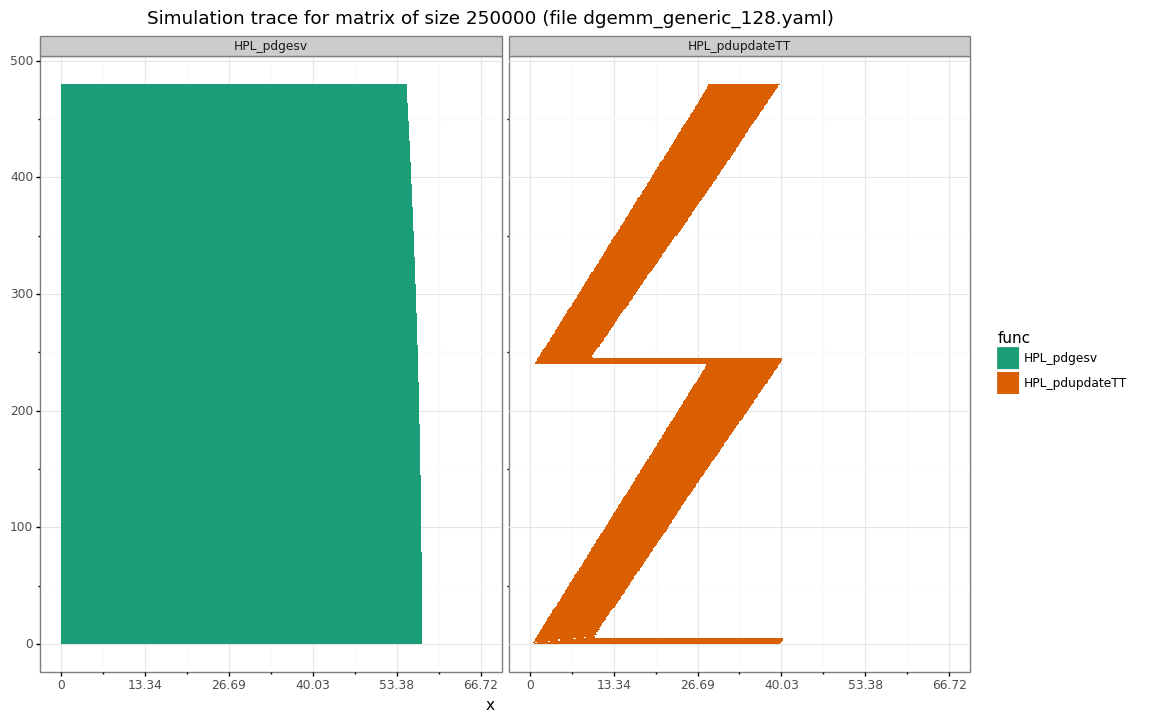

<ggplot: (8753309507830)>


In [16]:
for size in sorted(non_null_traces.matrix_size.unique()):
    tmp = non_null_traces[(non_null_traces['matrix_size'] == size)]
    special_functions = {'HPL_pdgesv', 'HPL_pdupdateTT'}
    tmp = tmp[tmp['function'].isin(special_functions)].copy()
    tmp['func'] = tmp['function']
    lines = my_range(non_null_traces.start.min(), non_null_traces.start.max(), 4)
    print(plot(tmp[tmp['mode'] == 'reality'], lines=lines) + ggtitle('Trace for matrix of size %d' % size) + facet_wrap('func'))
    for dgemm_file in sorted(traces[traces['mode'] != 'reality']['dgemm_file'].unique()):
        print(plot(tmp[(tmp['mode'] != 'reality') & (tmp['dgemm_file'] == dgemm_file)], lines=lines) + facet_wrap('func') + ggtitle('Simulation trace for matrix of size %d (file %s)' % (size, dgemm_file)))

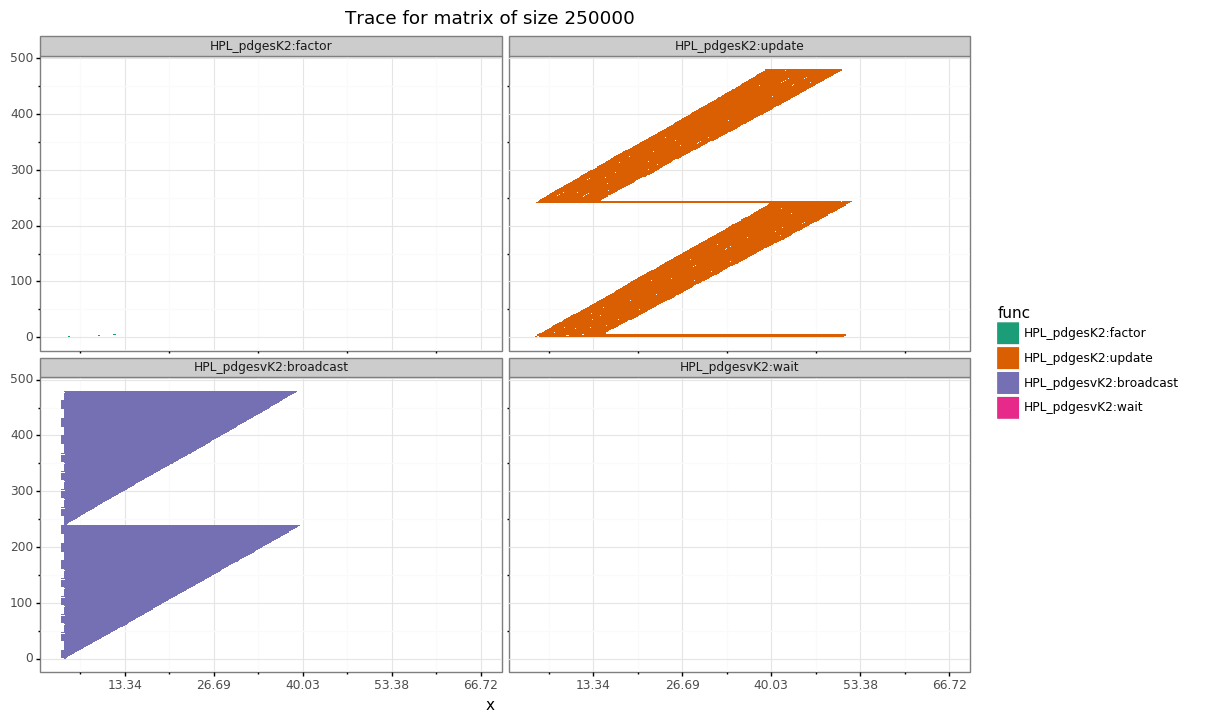

<ggplot: (8753298647037)>


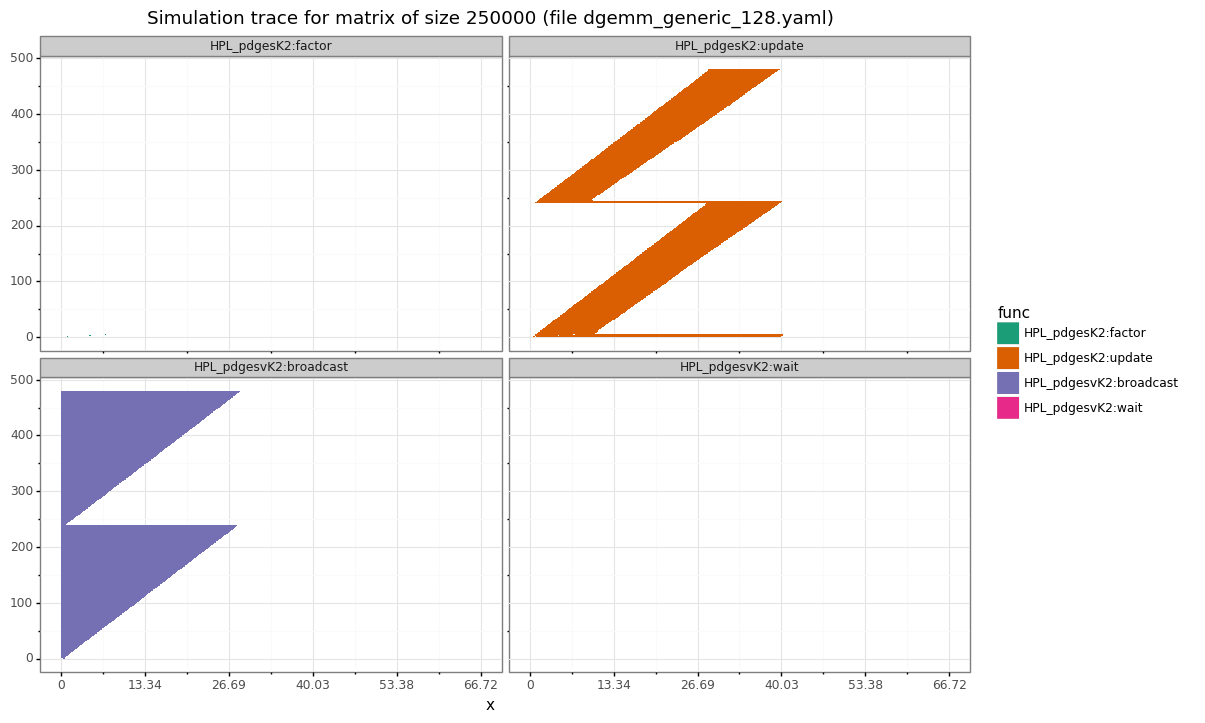

<ggplot: (-9223363283547278350)>


In [17]:
for size in sorted(non_null_traces.matrix_size.unique()):
    tmp = non_null_traces[(non_null_traces['matrix_size'] == size)]
    tmp = tmp[tmp['function'].str.contains('K2')]
    tmp['func'] = tmp['function']
    lines = my_range(non_null_traces.start.min(), non_null_traces.start.max(), 4)
    print(plot(tmp[tmp['mode'] == 'reality'], lines=lines) + ggtitle('Trace for matrix of size %d' % size) + facet_wrap('func'))
    for dgemm_file in sorted(traces[traces['mode'] != 'reality']['dgemm_file'].unique()):
        print(plot(tmp[(tmp['mode'] != 'reality') & (tmp['dgemm_file'] == dgemm_file)], lines=lines) + facet_wrap('func') + ggtitle('Simulation trace for matrix of size %d (file %s)' % (size, dgemm_file)))

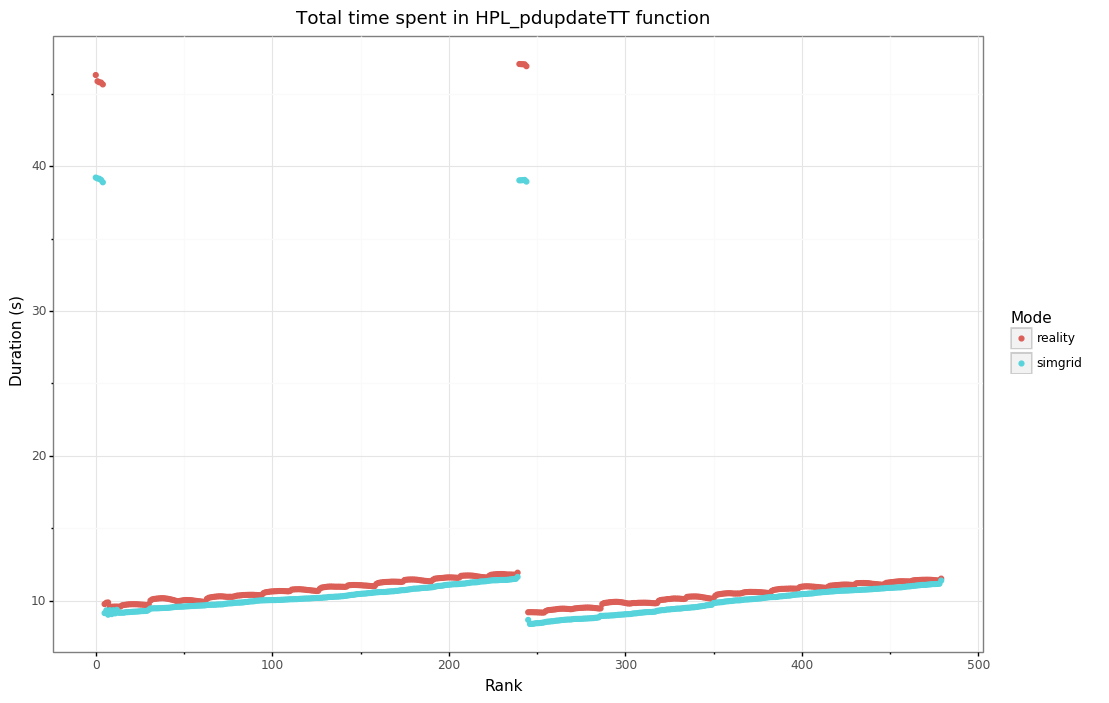

<ggplot: (-9223363283546988863)>

In [18]:
grouped = traces[traces['function'] == 'HPL_pdupdateTT'].groupby(['mode', 'rank'])[['duration']].sum().reset_index()
(ggplot(grouped)
    + aes(x='rank', y='duration', color='mode')
    + geom_point()
    + theme_bw()
    + labs(x='Rank', y='Duration (s)', color='Mode')
    + ggtitle('Total time spent in HPL_pdupdateTT function')
)

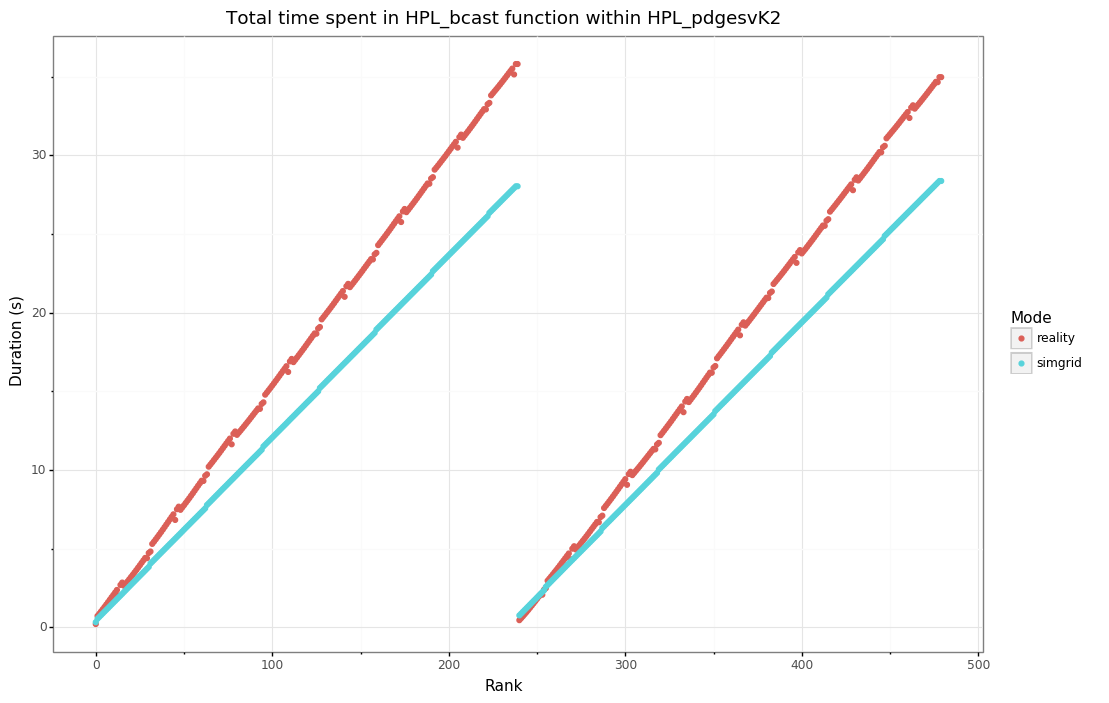

<ggplot: (8753307832829)>

In [19]:
grouped = traces[traces['function'] == 'HPL_pdgesvK2:broadcast'].groupby(['mode', 'rank'])[['duration']].sum().reset_index()
(ggplot(grouped)
    + aes(x='rank', y='duration', color='mode')
    + geom_point()
    + theme_bw()
    + labs(x='Rank', y='Duration (s)', color='Mode')
    + ggtitle('Total time spent in HPL_bcast function within HPL_pdgesvK2')
)

In [20]:
traces[(traces['function'] == 'HPL_pdgesvK2:broadcast') & (traces['rank'].isin([238, 239, 240]))][['mode', 'rank', 'start', 'end', 'function', 'file', 'line']].set_index(['mode', 'rank'])

start        end                function  \
mode    rank                                                
reality 238   3.819678  39.621688  HPL_pdgesvK2:broadcast   
        239   3.819679  39.621729  HPL_pdgesvK2:broadcast   
        240   4.164449   4.627606  HPL_pdgesvK2:broadcast   
simgrid 238   0.000273  28.033033  HPL_pdgesvK2:broadcast   
        239   0.000273  28.033033  HPL_pdgesvK2:broadcast   
        240   0.000268   0.768483  HPL_pdgesvK2:broadcast   

                                               file   line  
mode    rank                                                
reality 238                       ../HPL_pdgesvK2.c  166.0  
        239                       ../HPL_pdgesvK2.c  166.0  
        240                       ../HPL_pdgesvK2.c  166.0  
simgrid 238   /tmp/hpl-2.2/src/pgesv/HPL_pdgesvK2.c  166.0  
        239   /tmp/hpl-2.2/src/pgesv/HPL_pdgesvK2.c  166.0  
        240   /tmp/hpl-2.2/src/pgesv/HPL_pdgesvK2.c  166.0

In [21]:
traces[(traces['mode'] == 'reality') & (traces['rank'] == 238)].sort_values(by='start').head(n=30).reset_index(drop=True)

,dgemm_file,duration,end,file,function,k,kind,line,m,matrix_size,mode,msg_size,n,rank,rank+1,start,timestamp
0,NaN,3.100000e-05,0.002507,NaN,MPI_Recv,NaN,MPI,NaN,NaN,250000,reality,4,NaN,238,239,0.002476,NaN
1,NaN,9.000000e-06,0.002517,NaN,MPI_Send,NaN,MPI,NaN,NaN,250000,reality,4,NaN,238,239,0.002508,NaN
2,NaN,1.448000e-03,0.003966,NaN,MPI_Recv,NaN,MPI,NaN,NaN,250000,reality,4,NaN,238,239,0.002518,NaN
3,NaN,6.000000e-06,0.003972,NaN,MPI_Send,NaN,MPI,NaN,NaN,250000,reality,4,NaN,238,239,0.003966,NaN
4,NaN,2.000000e-05,0.004164,NaN,MPI_Recv,NaN,MPI,NaN,NaN,250000,reality,8,NaN,238,239,0.004144,NaN
5,NaN,5.000000e-06,0.004169,NaN,MPI_Send,NaN,MPI,NaN,NaN,250000,reality,8,NaN,238,239,0.004164,NaN
6,NaN,3.040000e-04,0.004474,NaN,MPI_Recv,NaN,MPI,NaN,NaN,250000,reality,8,NaN,238,239,0.004170,NaN
7,NaN,6.000000e-06,0.004480,NaN,MPI_Send,NaN,MPI,NaN,NaN,250000,reality,8,NaN,238,239,0.004474,NaN
8,NaN,3.000000e-05,0.004511,NaN,MPI_Recv,NaN,MPI,NaN,NaN,250000,reality,8,NaN,238,239,0.004481,NaN
9,NaN,6.000000e-06,0.004517,NaN,MPI_Send,NaN,MPI,NaN,NaN,250000,reality,8,NaN,238,239,0.004511,NaN


In [22]:
traces[(traces['mode'] == 'simgrid') & (traces['rank'] == 238)].sort_values(by='start').head(n=30).reset_index(drop=True)

,dgemm_file,duration,end,file,function,k,kind,line,m,matrix_size,mode,msg_size,n,rank,rank+1,start,timestamp
0,dgemm_generic_128.yaml,2.000000e-06,0.000002,NaN,MPI_Recv,NaN,MPI,NaN,NaN,250000,simgrid,4,NaN,238,239,0.000000,NaN
1,dgemm_generic_128.yaml,1.000000e-06,0.000003,NaN,MPI_Send,NaN,MPI,NaN,NaN,250000,simgrid,4,NaN,238,239,0.000002,NaN
2,dgemm_generic_128.yaml,3.100000e-05,0.000034,NaN,MPI_Recv,NaN,MPI,NaN,NaN,250000,simgrid,4,NaN,238,239,0.000003,NaN
3,dgemm_generic_128.yaml,1.000000e-06,0.000035,NaN,MPI_Send,NaN,MPI,NaN,NaN,250000,simgrid,4,NaN,238,239,0.000034,NaN
4,dgemm_generic_128.yaml,3.000000e-06,0.000038,NaN,MPI_Recv,NaN,MPI,NaN,NaN,250000,simgrid,8,NaN,238,239,0.000035,NaN
5,dgemm_generic_128.yaml,1.000000e-06,0.000039,NaN,MPI_Send,NaN,MPI,NaN,NaN,250000,simgrid,8,NaN,238,239,0.000038,NaN
6,dgemm_generic_128.yaml,3.200000e-05,0.000071,NaN,MPI_Recv,NaN,MPI,NaN,NaN,250000,simgrid,8,NaN,238,239,0.000039,NaN
7,dgemm_generic_128.yaml,2.000000e-06,0.000073,NaN,MPI_Send,NaN,MPI,NaN,NaN,250000,simgrid,8,NaN,238,239,0.000071,NaN
8,dgemm_generic_128.yaml,8.000000e-06,0.000081,NaN,MPI_Recv,NaN,MPI,NaN,NaN,250000,simgrid,8,NaN,238,239,0.000073,NaN
9,dgemm_generic_128.yaml,1.000000e-06,0.000082,NaN,MPI_Send,NaN,MPI,NaN,NaN,250000,simgrid,8,NaN,238,239,0.000081,NaN


In [23]:
256001032 * 1e-6

256.001032

In [24]:
traces[traces['msg_size'] == 256001032]

,dgemm_file,duration,end,file,function,k,kind,line,m,matrix_size,mode,msg_size,n,rank,rank+1,start,timestamp
42,NaN,0.143820,18.909835,NaN,MPI_Recv,NaN,MPI,NaN,NaN,250000,reality,256001032,NaN,99,100,18.766015,NaN
43,NaN,0.146314,19.056150,NaN,MPI_Send,NaN,MPI,NaN,NaN,250000,reality,256001032,NaN,99,100,18.909836,NaN
164,NaN,0.142675,18.766006,NaN,MPI_Recv,NaN,MPI,NaN,NaN,250000,reality,256001032,NaN,98,99,18.623331,NaN
165,NaN,0.143803,18.909810,NaN,MPI_Send,NaN,MPI,NaN,NaN,250000,reality,256001032,NaN,98,99,18.766007,NaN
288,NaN,0.143789,18.623322,NaN,MPI_Recv,NaN,MPI,NaN,NaN,250000,reality,256001032,NaN,97,98,18.479533,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8376025,dgemm_generic_128.yaml,0.112396,11.961059,NaN,MPI_Send,NaN,MPI,NaN,NaN,250000,simgrid,256001032,NaN,99,100,11.848663,NaN
8377140,dgemm_generic_128.yaml,0.112345,1.353556,NaN,MPI_Recv,NaN,MPI,NaN,NaN,250000,simgrid,256001032,NaN,9,10,1.241211,NaN
8377141,dgemm_generic_128.yaml,0.112827,1.466383,NaN,MPI_Send,NaN,MPI,NaN,NaN,250000,simgrid,256001032,NaN,9,10,1.353556,NaN
8378050,dgemm_generic_128.yaml,0.119111,0.442894,NaN,MPI_Send,NaN,MPI,NaN,NaN,250000,simgrid,256001032,NaN,0,1,0.323783,NaN


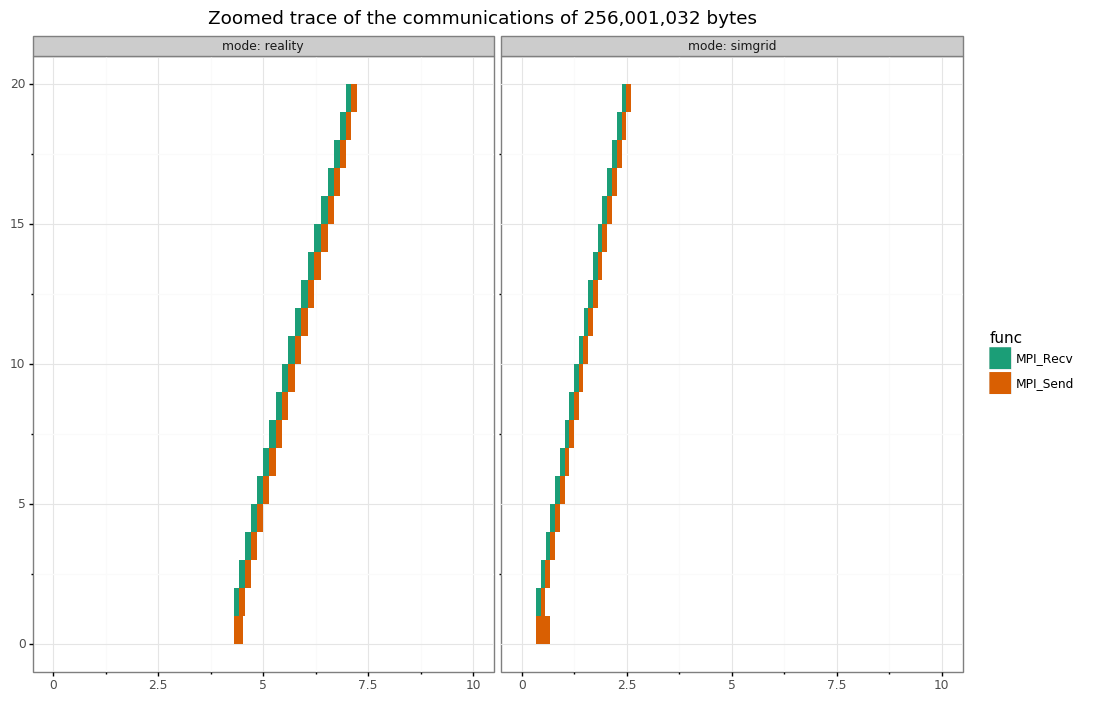

<ggplot: (-9223363283546819545)>

In [25]:
plot_bounded(non_null_traces[non_null_traces['msg_size'] == 256001032], 0, 10, range(20), wrap=['mode']) + ggtitle('Zoomed trace of the communications of 256,001,032 bytes')

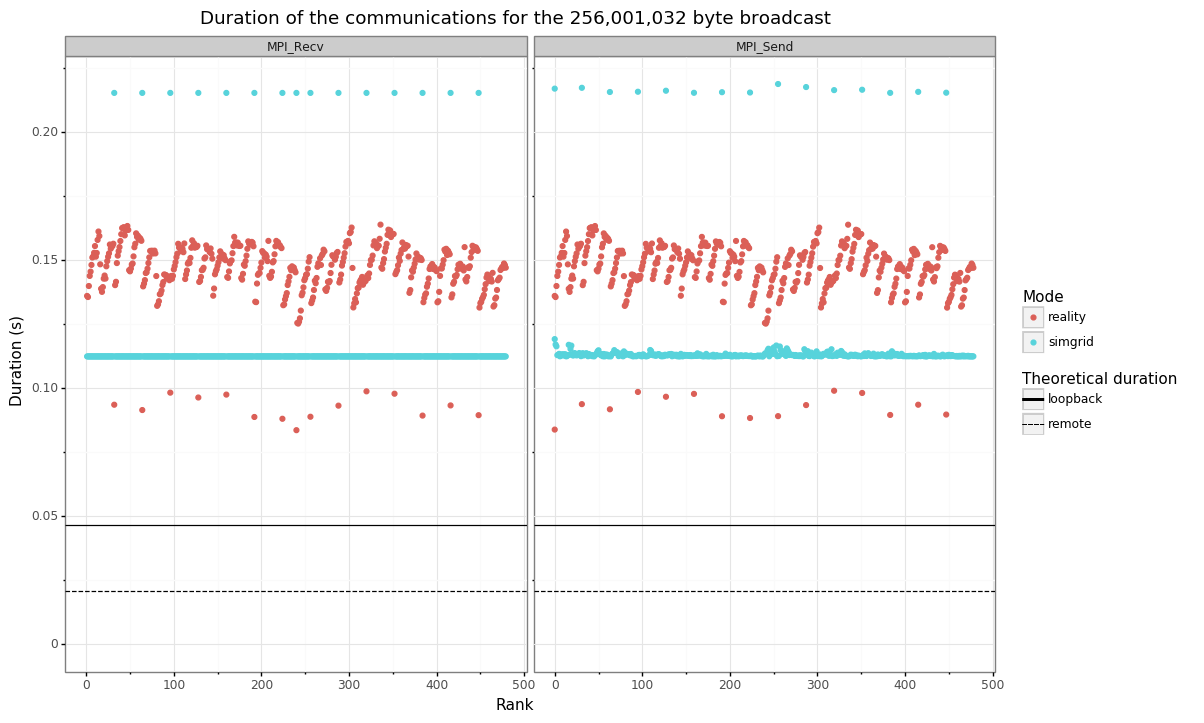

<ggplot: (-9223363283546557664)>

In [26]:
size = 256001032
bw_factor = 0.9868
lat_factor = 129.25
loopback_bw_factor = 0.22
loopback_lat_factor = 0
theoretical_remote   = (0.01e-6*lat_factor) + size/(12.5e9*bw_factor)
theoretical_loopback = (0.01e-6*loopback_lat_factor) + size/(25e9*loopback_bw_factor)

theoretical = pandas.DataFrame([
    {'duration': theoretical_remote,   'com': 'remote'},
    {'duration': theoretical_loopback, 'com': 'loopback'},
])

(ggplot(non_null_traces[non_null_traces['msg_size'] == size])
    + aes(x='rank', y='duration', color='mode')
    + geom_point()
    + theme_bw()
    + facet_wrap('function')
    + labs(x='Rank', y='Duration (s)', color='Mode', linetype='Theoretical duration')
    + expand_limits(y=0)
    + geom_hline(aes(yintercept='duration', linetype='com'), data=theoretical)
    + ggtitle('Duration of the communications for the 256,001,032 byte broadcast')
)